# Project 1 - Analysis of Canadian Banks

## Import Python Libraries

In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
#pip install -i https://pypi.anaconda.org/ranaroussi/simple yfinance

## Load Data

### 1. Read CSV

In [4]:
# Use the Pathlib libary to set the path to the CSV
# CAD Banks
bmo_path = Path("../data/BMO_Close_Jan2016-Jun2022.csv")
bns_path = Path("../data/BNS_Close_Jan2016-Jun2022.csv")
cm_path = Path("../data/CM_Close_Jan2016-Jun2022.csv")
na_path = Path("../data/NA_Close_Jan2016-Jun2022.csv")
ry_path = Path("../data/RY_Close_Jan2016-Jun2022.csv")
td_path = Path("../data/TD_Close_Jan2016-Jun2022.csv")

#CAD Bank ETF
zeb_path = Path("../data/ZEB_Close_Jan2016-Jun2022.csv")
zgb_path = Path("../data/ZGB_Close_Jan2016-Jun2022.csv")
zwb_path = Path("../data/ZWB_Close_Jan2016-Jun2022.csv")

# Commodities
cd_path = Path("../data/CD_10Year.txt")
cl_path = Path("../data/CL_10Year.txt")
dx_path = Path("../data/DX_10Year.txt")


### 2. Yahoo Finance API

In [5]:
# List the ticker symbols for the stocks of interest
lst=['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]


# Determine the start and end dates
start_date = '2019-08-01'
end_date = '2022-07-31'

# Create empty dataframe to hold stock data
dfAllStocks_Test=pd.DataFrame()

# Gathers stock data from listed tickers and combines them into a dataframe
for ticker in lst:
    # Create data frame from API in loop 
    df= yf.download(ticker, start= start_date, end= end_date)
    # Remove to '.TO' suffix from Canadian stocks
    tic= ticker.replace('.TO','')
    df['Ticker']=tic
    # Drop unwanted coloumns - Keep Adjusted Close
    df.drop(columns= ["Open", "High", "Low", "Volume", "Close", "Ticker"], inplace= True)
    # Combine individual stocks into a single data frame
    dfAllStocks_Test=pd.concat([dfAllStocks_Test, df], axis= 1)

# Rename the coloumns to the ticker symbols in the list
dfAllStocks_Test.columns = lst
# Drop the N/As
dfAllStocks_Test = dfAllStocks_Test.dropna()

# Remove the timestamp from the date
dfAllStocks_Test["Date"] = dfAllStocks_Test.index
dfAllStocks_Test["Date"] = dfAllStocks_Test["Date"].dt.date
dfAllStocks_Test.set_index("Date", inplace=True)

# Display the data
display(dfAllStocks_Test)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL
Date,,,,,,,,,,
2019-08-01,85.727745,59.001900,43.352688,56.892372,91.301071,66.986351,25.103245,15.039157,20.861189,66.459221
2019-08-02,85.067955,58.580879,43.060848,56.464466,90.741692,66.343086,24.926216,14.923154,20.833279,66.403259
2019-08-06,83.625229,57.713573,42.223396,55.992004,89.685120,65.682213,24.581001,14.732570,21.084507,65.144196
2019-08-07,83.757187,58.092503,42.472950,56.268345,89.960365,65.523582,24.678366,14.782291,21.112421,65.694466
2019-08-08,84.161865,58.412468,42.866287,56.304008,90.404297,66.122810,24.802299,14.856863,21.075203,66.878906
...,...,...,...,...,...,...,...,...,...,...
2022-07-25,125.025871,74.552597,62.432636,88.986610,123.099998,82.470001,34.396786,18.637020,19.395838,77.849998
2022-07-26,124.471954,74.670715,62.195889,86.849037,121.849998,81.400002,34.099922,18.489656,19.445621,78.529999
2022-07-27,125.925972,75.497543,62.817352,88.095947,122.650002,82.440002,34.457405,18.657652,19.505362,78.760002


### 3. Create Individual Dataframes

In [6]:
# Read in regional_revenue.csv file into a Pandas DataFrame
# CAD Banks
bmo_df = pd.read_csv(bmo_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
bmo_df.columns = ["BMO"]
bns_df = pd.read_csv(bns_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
bns_df.columns = ["BNS"]
cm_df = pd.read_csv(cm_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
cm_df.columns = ["CM"]
na_df = pd.read_csv(na_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
na_df.columns = ["NA"]
ry_df = pd.read_csv(ry_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
ry_df.columns = ["RY"]
td_df = pd.read_csv(td_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
td_df.columns = ["TD"]

# CAD Bank ETFs
zeb_df = pd.read_csv(zeb_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
zeb_df.columns = ["ZEB"]
zwb_df = pd.read_csv(zwb_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
zwb_df.columns = ["ZWB"]
zgb_df = pd.read_csv(zgb_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
zgb_df.columns = ["ZGB"]

# Commodities
cd_df = pd.read_csv(cd_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
cd_df = cd_df.drop(columns=['Time', 'Open', 'High', 'Low', 'Vol', 'OI'])
cd_df.columns = ["CD"]
cd_df['CD'] = cd_df['CD'] * 100
cl_df = pd.read_csv(cl_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
cl_df = cl_df.drop(columns=['Time', 'Open', 'High', 'Low', 'Vol', 'OI'])
cl_df.columns = ["CL"]
dx_df = pd.read_csv(dx_path, index_col = "Date", parse_dates = True, infer_datetime_format=True)
dx_df = dx_df.drop(columns=['Time', 'Open', 'High', 'Low', 'Vol', 'OI'])
dx_df.columns = ["DX"]

df_list_Banks = [bmo_df, bns_df, cm_df, na_df, ry_df, td_df]
df_list_ETFs = [zeb_df, zwb_df, zgb_df]
df_list_Comm = [cd_df,dx_df, cl_df]
df_list_Comm = [cd_df,dx_df]

# Review the DataFrame
#display(cd_df.head())
#display(dx_df.tail())
#display(zwb_df.describe())

# Count nulls
#display(zwb_df.isnull().sum())

### 4. Concatinate Indicidual Dataframes

In [7]:
# Join Whale Returns, Algorithmic Returns, and the S&P TSX 60 Returns into a single DataFrame with columns for each portfolio's returns.
all_stocks_df = pd.concat([dfAllStocks_Test, cd_df, dx_df], axis="columns", join="inner")

# Ensure data sorted by index 
all_stocks_df.sort_index(inplace = True)

# Display sample data
all_stocks_df.head()

C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:347: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.inner_join_indexer(sv, ov)


,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2019-08-01,85.727745,59.001900,43.352688,56.892372,91.301071,66.986351,25.103245,15.039157,20.861189,66.459221,75.750,96.508
2019-08-02,85.067955,58.580879,43.060848,56.464466,90.741692,66.343086,24.926216,14.923154,20.833279,66.403259,75.875,96.216
2019-08-06,83.625229,57.713573,42.223396,55.992004,89.685120,65.682213,24.581001,14.732570,21.084507,65.144196,75.475,95.781
2019-08-07,83.757187,58.092503,42.472950,56.268345,89.960365,65.523582,24.678366,14.782291,21.112421,65.694466,75.275,95.709
2019-08-08,84.161865,58.412468,42.866287,56.304008,90.404297,66.122810,24.802299,14.856863,21.075203,66.878906,75.715,95.798


## Exploratory Data Analysis (EDA)

### 1. Summary Statistics

In [8]:
# Explore the whale data further
all_stocks_df.describe()

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
count,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000
mean,102.101433,66.885844,55.919219,75.120417,107.297629,73.898748,29.930678,16.976878,21.254485,73.775501,77.231917,95.275955
std,26.473124,12.554063,12.719517,16.585835,19.104539,14.697022,6.246646,2.911893,0.909308,5.930907,2.729490,4.041080
min,50.513401,40.303013,29.356441,35.225075,65.423874,44.311592,16.432522,9.798410,18.411190,56.550182,68.715000,88.887000
25%,81.579630,57.534729,46.068867,61.278818,90.886793,63.294254,24.553746,14.669803,20.896662,68.891676,75.536250,92.125000
50%,92.724197,64.956211,52.132956,68.757149,101.167427,70.534981,28.014839,16.250624,21.284113,75.017422,77.620000,95.539000
75%,124.217009,75.377560,68.074278,91.427135,125.029507,83.657240,35.217702,19.433714,21.968835,78.329226,79.210000,97.201500
max,150.601822,90.721008,80.198830,101.456551,144.738052,105.727989,41.594479,22.295883,22.678158,83.872482,83.055000,108.142000


### 2. Daily Closing Prices

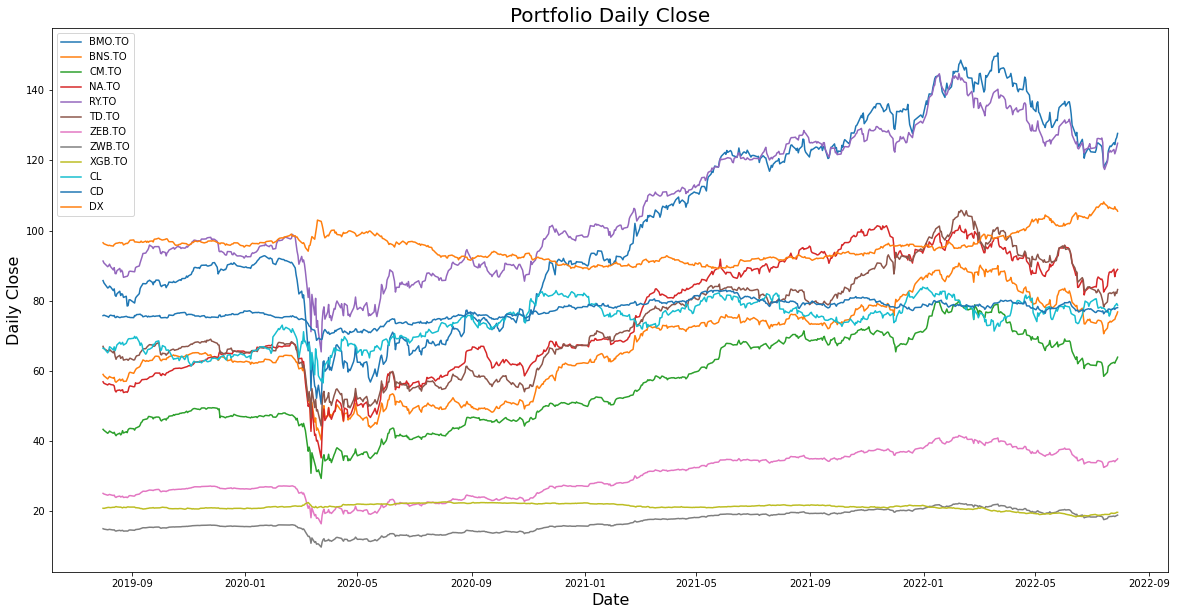

In [9]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(all_stocks_df)
plt.title("Portfolio Daily Close", fontsize = 20)
plt.ylabel("Daily Close", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_df.columns)

plt.show()


### 3. Daily Returns

In [10]:
# Calculate Daily Returns
# Drop nulls
all_stocks_returns_df = all_stocks_df.pct_change().dropna().copy()

#Shorten the column names
#all_stocks_returns_df.columns = ["ZEB","ZWB","RY","TD"]

# Display sample data
all_stocks_returns_df.head()

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2019-08-02,-0.007696,-0.007136,-0.006732,-0.007521,-0.006127,-0.009603,-0.007052,-0.007713,-0.001338,-0.000842,0.001650,-0.003026
2019-08-06,-0.016960,-0.014805,-0.019448,-0.008367,-0.011644,-0.009961,-0.013849,-0.012771,0.012059,-0.018961,-0.005272,-0.004521
2019-08-07,0.001578,0.006566,0.005910,0.004935,0.003069,-0.002415,0.003961,0.003375,0.001324,0.008447,-0.002650,-0.000752
2019-08-08,0.004832,0.005508,0.009261,0.000634,0.004935,0.009145,0.005022,0.005045,-0.001763,0.018030,0.005845,0.000930
2019-08-09,-0.002404,-0.003604,-0.004243,-0.003167,-0.007268,-0.004798,-0.003926,-0.003904,-0.001766,-0.002650,0.002179,-0.001169


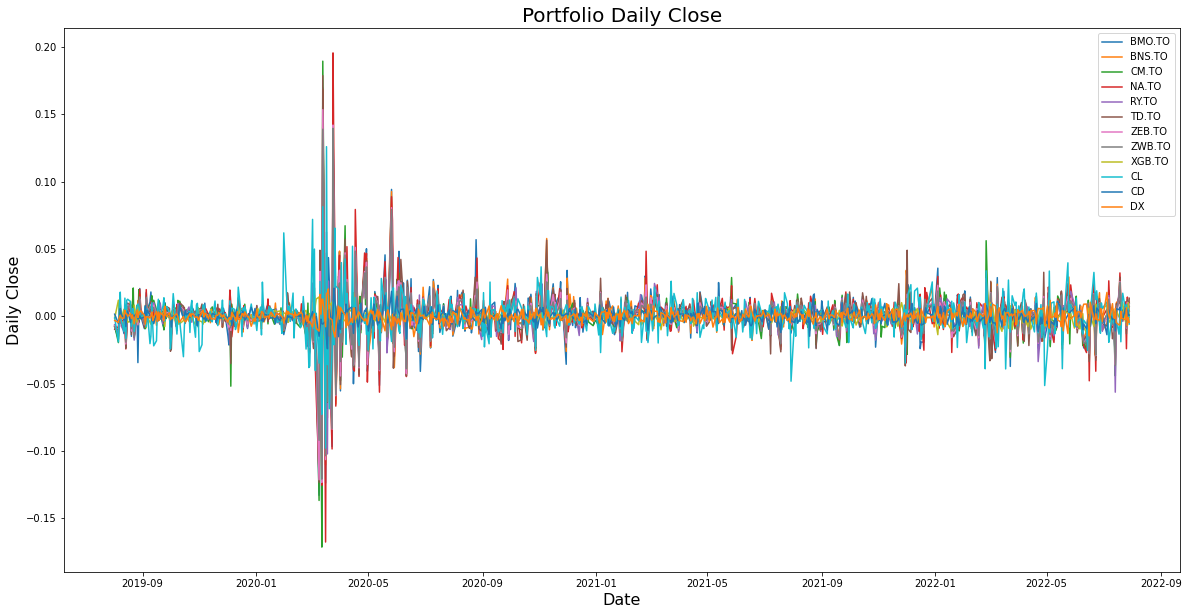

In [11]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(all_stocks_returns_df)
plt.title("Portfolio Daily Close", fontsize = 20)
plt.ylabel("Daily Close", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_returns_df.columns)

plt.show()


### 4. Cumulative Daily Returns

In [12]:
# Calculate cumulative returns of all portfolios
all_stocks_cumulative_returns = (1 + all_stocks_returns_df).cumprod()

# Display sample data
all_stocks_cumulative_returns.tail()      

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2022-07-25,1.458406,1.263563,1.440110,1.564122,1.348286,1.231146,1.370213,1.239233,0.929757,1.171395,1.027393,1.099287
2022-07-26,1.451945,1.265565,1.434649,1.526550,1.334595,1.215173,1.358387,1.229434,0.932143,1.181627,1.023432,1.106426
2022-07-27,1.468906,1.279578,1.448984,1.548467,1.343358,1.230699,1.372628,1.240605,0.935007,1.185088,1.028119,1.099038
2022-07-28,1.475252,1.287920,1.459906,1.556642,1.355406,1.225175,1.379352,1.248490,0.944553,1.191558,1.029175,1.098054
2022-07-29,1.489133,1.301433,1.474014,1.562904,1.367563,1.241746,1.392010,1.257690,0.944076,1.184787,1.030165,1.093319


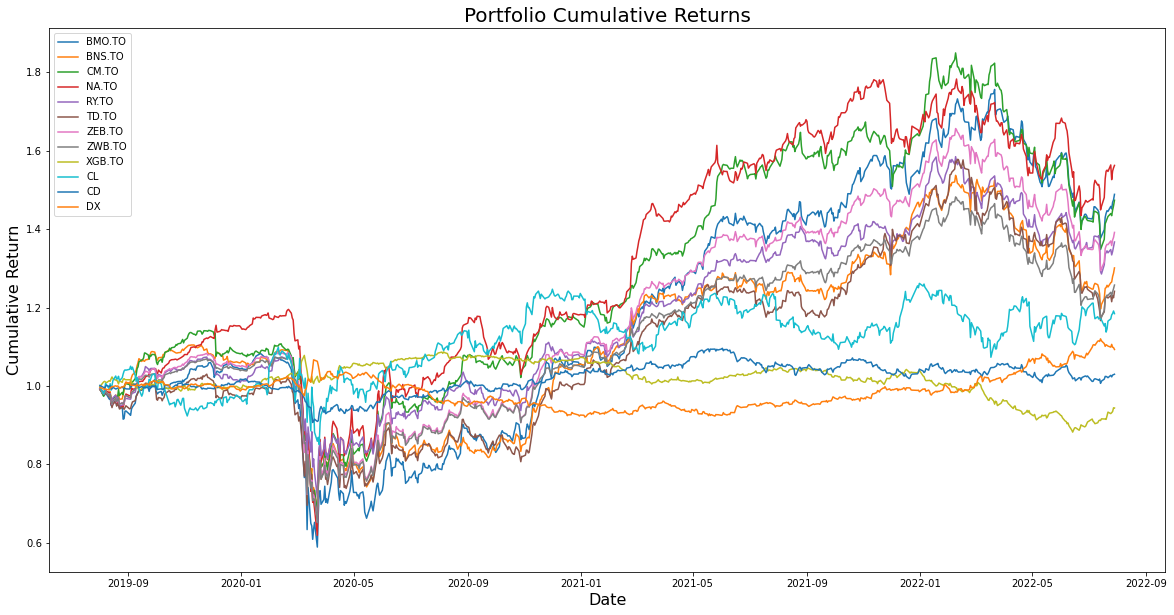

In [13]:
# Plot cumulative returns
fig = plt.figure(figsize=(20,10))

plt.plot(all_stocks_cumulative_returns)
plt.title("Portfolio Cumulative Returns", fontsize = 20)
plt.ylabel("Cumulative Return", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_cumulative_returns.columns)

plt.show()

### 5. Box Plot - Daily Returns

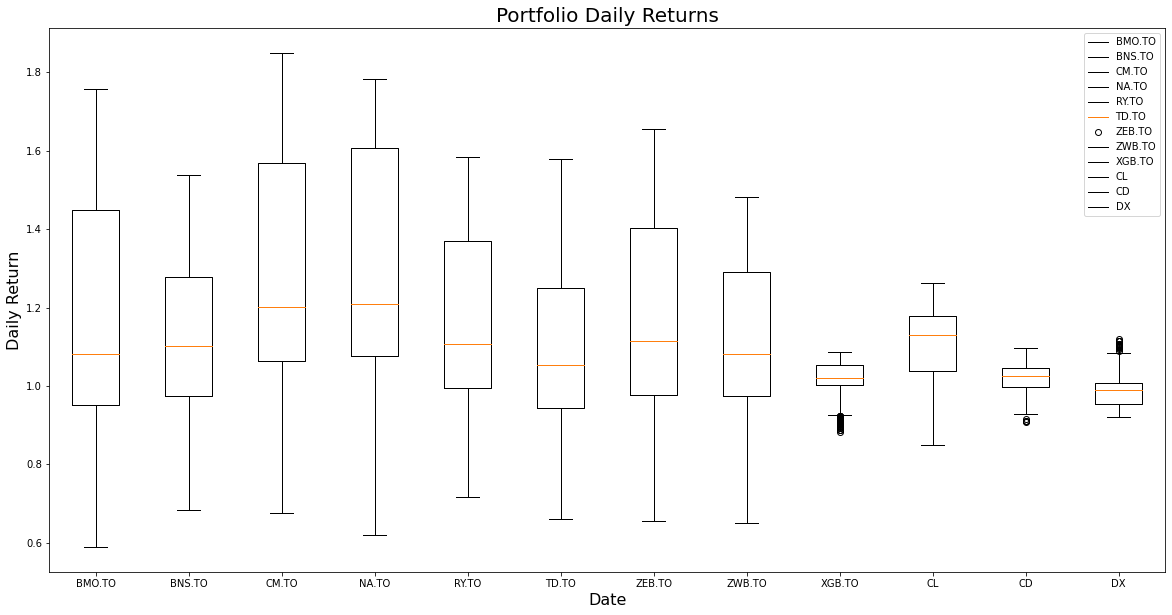

In [14]:
# Box plot to visually show risk
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

plt.boxplot(all_stocks_cumulative_returns)
plt.title("Portfolio Daily Returns", fontsize = 20)
plt.ylabel("Daily Return", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(all_stocks_cumulative_returns.columns)
ax.set_xticklabels(all_stocks_cumulative_returns.columns)

plt.show()

### 6. Calculate and plot rolling `std` with 21-day window

In [15]:
# Calculate rolling standard deviation
rolling_std_21 = all_stocks_cumulative_returns.rolling(21).std().dropna().sort_index()

# Display sample data
rolling_std_21.head()

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
Date,,,,,,,,,,,,
2019-09-03,0.021036,0.013853,0.013744,0.016131,0.012604,0.016998,0.012107,0.011791,0.005360,0.018638,0.003071,0.004879
2019-09-04,0.020124,0.015345,0.013800,0.015240,0.011366,0.015849,0.010835,0.010598,0.004180,0.019907,0.002957,0.004989
2019-09-05,0.019462,0.017557,0.014762,0.016025,0.011199,0.014980,0.011000,0.010820,0.004358,0.018822,0.003050,0.004914
2019-09-06,0.018461,0.020003,0.015843,0.016178,0.010948,0.014148,0.011186,0.011005,0.004563,0.018398,0.003455,0.004727
2019-09-09,0.016955,0.022668,0.017501,0.016489,0.010444,0.012296,0.011564,0.011355,0.005077,0.018042,0.003845,0.004517


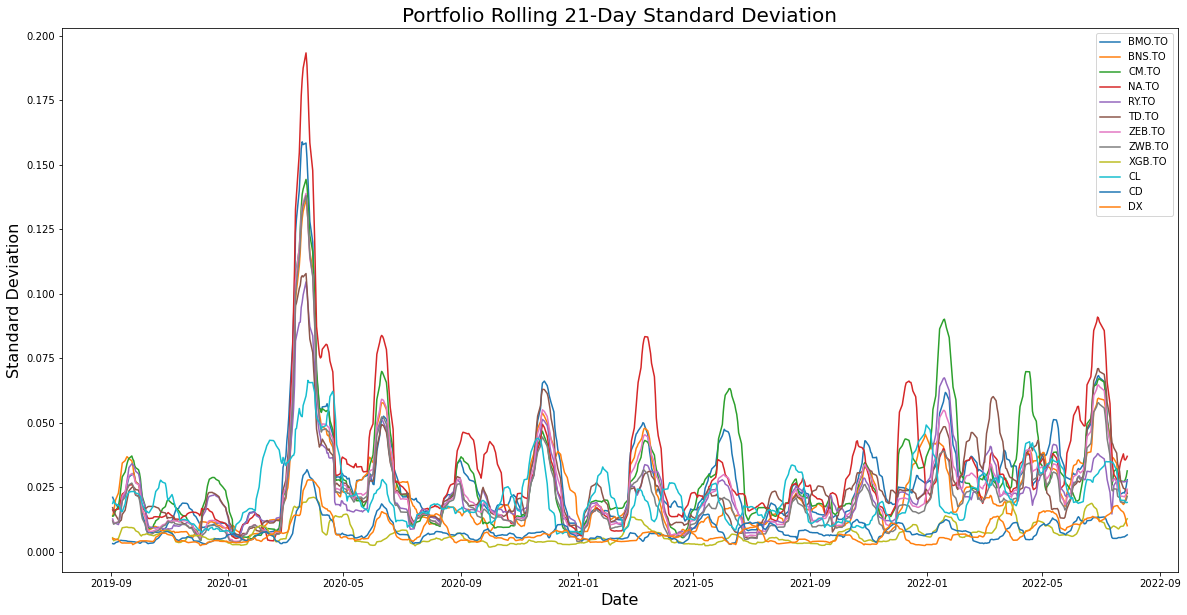

In [16]:
# Plot rolling standard deviation
fig = plt.figure(figsize=(20,10))

plt.plot(rolling_std_21)
plt.title("Portfolio Rolling 21-Day Standard Deviation", fontsize = 20)
plt.ylabel("Standard Deviation", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(rolling_std_21.columns)

plt.show()

### 7. Calculate and plot the correlation

In [17]:
# Calculate and plot the correlation
correlation = all_stocks_cumulative_returns.corr()

# Display Correlation Matrix
correlation

,BMO.TO,BNS.TO,CM.TO,NA.TO,RY.TO,TD.TO,ZEB.TO,ZWB.TO,XGB.TO,CL,CD,DX
BMO.TO,1.000000,0.978586,0.981468,0.967521,0.990374,0.986001,0.996438,0.991728,-0.582935,0.611700,0.781187,0.094099
BNS.TO,0.978586,1.000000,0.951047,0.925236,0.964585,0.986212,0.979704,0.981400,-0.605037,0.542420,0.769908,0.086980
CM.TO,0.981468,0.951047,1.000000,0.981594,0.990826,0.965516,0.990309,0.985965,-0.454986,0.662374,0.807074,-0.025371
NA.TO,0.967521,0.925236,0.981594,1.000000,0.974743,0.941691,0.977115,0.973347,-0.436876,0.674438,0.830032,-0.047134
RY.TO,0.990374,0.964585,0.990826,0.974743,1.000000,0.979541,0.995005,0.987365,-0.533402,0.656518,0.780315,0.062929
TD.TO,0.986001,0.986212,0.965516,0.941691,0.979541,1.000000,0.988203,0.982912,-0.589217,0.594080,0.760579,0.096419
ZEB.TO,0.996438,0.979704,0.990309,0.977115,0.995005,0.988203,1.000000,0.996452,-0.540589,0.630892,0.800023,0.043308
ZWB.TO,0.991728,0.981400,0.985965,0.973347,0.987365,0.982912,0.996452,1.000000,-0.521106,0.619333,0.821915,0.001519
XGB.TO,-0.582935,-0.605037,-0.454986,-0.436876,-0.533402,-0.589217,-0.540589,-0.521106,1.000000,-0.033826,-0.244027,-0.701378
CL,0.611700,0.542420,0.662374,0.674438,0.656518,0.594080,0.630892,0.619333,-0.033826,1.000000,0.704015,-0.311000


<AxesSubplot:>

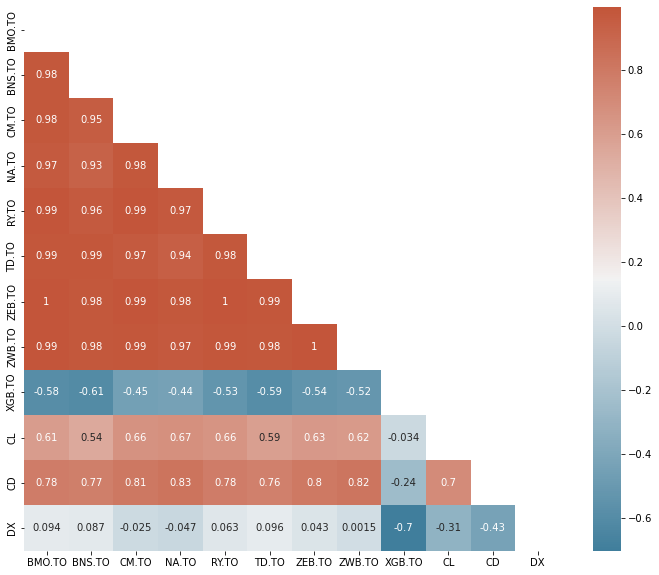

In [18]:
# Correlation between different variables
corr = all_stocks_cumulative_returns.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# Reference: https://vitalflux.com/correlation-heatmap-with-seaborn-pandas/

### 8. Calculate and Plot the 60-day Rolling Beta for Your Portfolio compared to the S&P 60 TSX

In [19]:
zeb_beta = all_stocks_cumulative_returns['XGB.TO']
zeb_beta

Date
2019-08-02    0.998662
2019-08-06    1.010705
2019-08-07    1.012043
2019-08-08    1.010259
2019-08-09    1.008475
                ...   
2022-07-25    0.929757
2022-07-26    0.932143
2022-07-27    0.935007
2022-07-28    0.944553
2022-07-29    0.944076
Name: XGB.TO, Length: 737, dtype: float64

In [20]:
# Calculate and plot Beta

# Calculate covariance of a single portfolio
bmo_covariance_roll_21 = all_stocks_cumulative_returns['BMO.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
bns_covariance_roll_21 = all_stocks_cumulative_returns['BNS.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
cm_covariance_roll_21 = all_stocks_cumulative_returns['CM.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
na_covariance_roll_21 = all_stocks_cumulative_returns['NA.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
ry_covariance_roll_21 = all_stocks_cumulative_returns['RY.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
td_covariance_roll_21 = all_stocks_cumulative_returns['TD.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
zeb_covariance_roll_21 = all_stocks_cumulative_returns['ZEB.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])
zwb_covariance_roll_21 = all_stocks_cumulative_returns['ZWB.TO'].rolling(60).cov(all_stocks_cumulative_returns["XGB.TO"])

# Calculate variance of S&P TSX
zgb_60_variance_roll_21 = all_stocks_cumulative_returns["XGB.TO"].rolling(60).var()

# Computing beta
bmo_beta_roll_21 = round((bmo_covariance_roll_21/zgb_60_variance_roll_21),4)
bns_beta_roll_21 = round((bns_covariance_roll_21/zgb_60_variance_roll_21),4)
cm_beta_roll_21 = round((cm_covariance_roll_21/zgb_60_variance_roll_21),4)
na_beta_roll_21 = round((na_covariance_roll_21/zgb_60_variance_roll_21),4)
ry_beta_roll_21 = round((ry_covariance_roll_21/zgb_60_variance_roll_21),4)
td_beta_roll_21 = round((td_covariance_roll_21/zgb_60_variance_roll_21),4)
zeb_beta_roll_21 = round((zeb_covariance_roll_21/zgb_60_variance_roll_21),4)
zwb_beta_roll_21 = round((zwb_covariance_roll_21/zgb_60_variance_roll_21),4)

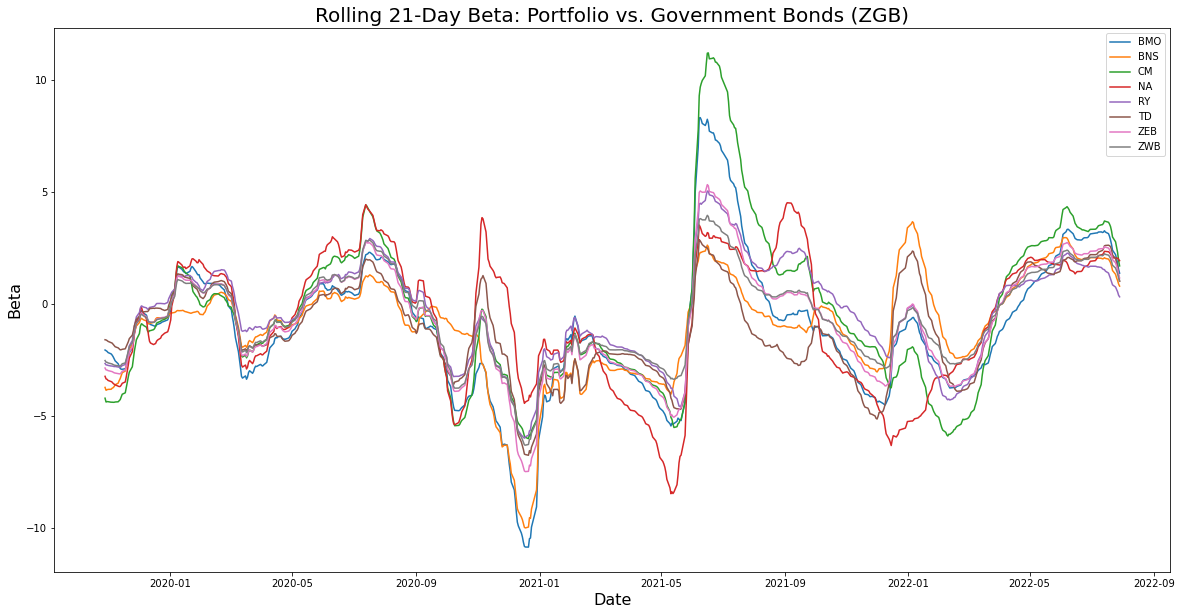

In [21]:
# Plot beta trend
fig = plt.figure(figsize=(20,10))

plt.plot(bmo_beta_roll_21)
plt.plot(bns_beta_roll_21)
plt.plot(cm_beta_roll_21)
plt.plot(na_beta_roll_21)
plt.plot(ry_beta_roll_21)
plt.plot(td_beta_roll_21)
plt.plot(zeb_beta_roll_21)
plt.plot(zwb_beta_roll_21)
plt.title("Rolling 21-Day Beta: Portfolio vs. Government Bonds (XGB.TO)", fontsize = 20)
plt.ylabel("Beta", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(['BMO','BNS','CM','NA','RY','TD','ZEB','ZWB'])

plt.show()

### 9. Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [22]:
# Calculate Annualized Sharpe Ratios
sharpe_ratios = pd.DataFrame((all_stocks_cumulative_returns.mean() * 252) / (all_stocks_cumulative_returns.std() * np.sqrt(252)), columns = ['Sharpe']).sort_values(by = "Sharpe")

# Display data sorted from lowest to highest risk adjusted return
sharpe_ratios.sort_values("Sharpe")

,Sharpe
BMO.TO,61.212407
CM.TO,69.809816
NA.TO,71.932590
ZEB.TO,76.058264
TD.TO,79.787264
BNS.TO,84.555371
RY.TO,89.156662
ZWB.TO,92.530685
CL,197.562419
XGB.TO,370.860890


<AxesSubplot:title={'center':'Portfolio Sharpe Ratios'}>

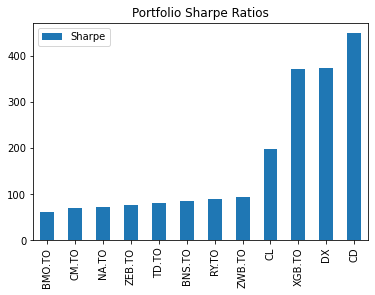

In [23]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind = "bar", title = "Portfolio Sharpe Ratios")

## Part 2 - Retirement Planning

### Monte Carlo Simulation